# Survival Analysis

In [1]:
# If we're running on Colab, install empiricaldist
# https://pypi.org/project/empiricaldist/

import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install empiricaldist

In [2]:
# Get utils.py

from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
    
download('https://github.com/AllenDowney/ThinkBayes2/raw/master/soln/utils.py')

In [3]:
from utils import set_pyplot_params
set_pyplot_params()

The following cell downloads the data.

In [4]:
download('https://github.com/AllenDowney/ThinkBayes2/raw/master/examples/Osogbo2021.csv')

I'll use Pandas to load the data into a `DataFrame`.

In [5]:
import pandas as pd

df = pd.read_csv('Osogbo2021.csv')
df.head()

,TIME(In Days),AGE OF PATIENTS,CENSOR,AGE AT MENARACHE,BREASTFEED,CONTRACEPT,DETECTION,NEOADJUVANT
0,48,44,1,18,1.5,2,1,2
1,898,43,0,17,1.0,1,1,2
2,36,40,0,15,2.0,2,1,2
3,23,56,1,15,1.5,1,1,1
4,300,53,0,12,1.0,2,1,2


In [7]:
duration = df['TIME(In Days)']

In [8]:
import numpy as np

log_duration = np.log10(duration)

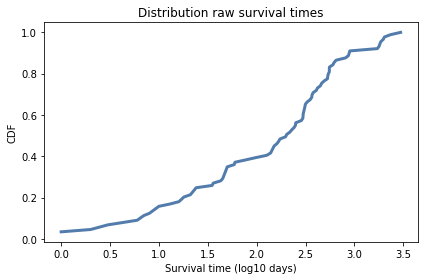

In [9]:
from empiricaldist import Cdf
from utils import decorate

cdf = Cdf.from_seq(log_duration)
cdf.plot()
    
decorate(xlabel='Survival time (log10 days)', 
         ylabel='CDF',
         title='Distribution raw survival times')

In [10]:
mu = log_duration.mean()
sigma = log_duration.std()
mu, sigma

(2.064186566935665, 0.849952354519006)

In [11]:
from empiricaldist import Pmf

def make_uniform(qs, name=None, **options):
    """Make a Pmf that represents a uniform distribution."""
    pmf = Pmf(1.0, qs, **options)
    pmf.normalize()
    if name:
        pmf.index.name = name
    return pmf

In [12]:
import numpy as np

qs = np.linspace(2, 4, num=101)
prior_mu = make_uniform(qs, name='mean')

I chose the lower and upper bounds by trial and error.
I'll explain how when we look at the posterior distribution.

Here's the prior distribution for `sigma`:

In [13]:
qs = np.linspace(0.01, 1, num=90)
prior_sigma = make_uniform(qs, name='std')

Now we can use `make_joint` to make the joint prior distribution.

In [14]:
from utils import make_joint

prior = make_joint(prior_mu, prior_sigma)

And we'll start by working with the data from the control group.

In [15]:
complete = (df['CENSOR'] == 0)
data_complete = log_duration[complete]
data_ongoing = log_duration[~complete]

len(data_complete), len(data_ongoing)

(38, 51)

## Likelihood

First update

In [16]:
mu_mesh, sigma_mesh, data_mesh = np.meshgrid(
    prior.columns, prior.index, data_complete)

mu_mesh.shape

(90, 101, 38)

In [17]:
from scipy.stats import norm

densities = norm(mu_mesh, sigma_mesh).pdf(data_mesh)
densities.shape

(90, 101, 38)

In [18]:
likelihood = densities.prod(axis=2)
likelihood.shape

(90, 101)

In [19]:
from utils import normalize

posterior = prior * likelihood
normalize(posterior)
posterior.shape

(90, 101)

Second update

In [20]:
mu_mesh, sigma_mesh, data_mesh = np.meshgrid(
    prior.columns, prior.index, data_ongoing)

mu_mesh.shape

(90, 101, 51)

In [21]:
from scipy.stats import norm

densities = norm(mu_mesh, sigma_mesh).sf(data_mesh)
densities.shape

(90, 101, 51)

In [22]:
likelihood = densities.prod(axis=2)
likelihood.shape

(90, 101)

In [23]:
from utils import normalize

posterior2 = posterior * likelihood
normalize(posterior2)
posterior2.shape

(90, 101)

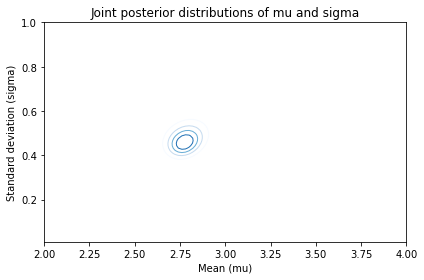

In [24]:
import matplotlib.pyplot as plt
from utils import plot_contour

plot_contour(posterior2, cmap='Blues')

decorate(xlabel='Mean (mu)', 
         ylabel='Standard deviation (sigma)',
         title='Joint posterior distributions of mu and sigma')

## Posterior Marginal Distributions

I'll use `marginal`, which we saw in <<_MarginalDistributions>>, to extract the posterior marginal distributions for the population means.

In [25]:
from utils import marginal



Here's what they look like:

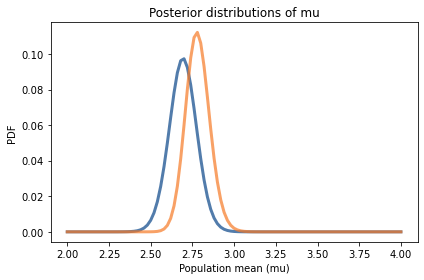

In [26]:
pmf_mean = marginal(posterior, 0)
pmf_mean.plot()

pmf_mean2 = marginal(posterior2, 0)
pmf_mean2.plot()

decorate(xlabel='Population mean (mu)', 
         ylabel='PDF', 
         title='Posterior distributions of mu')

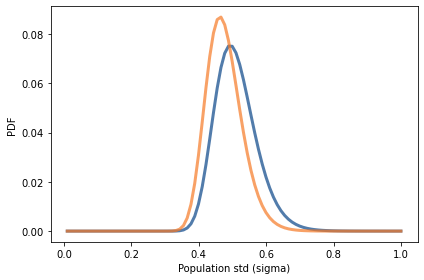

In [27]:
pmf_std = marginal(posterior, 1)
pmf_std.plot()

pmf_std2 = marginal(posterior2, 1)
pmf_std2.plot()

decorate(xlabel='Population std (sigma)', 
         ylabel='PDF')

In [29]:
pmf_mean2.idxmax(), pmf_std2.idxmax()

(2.7800000000000002, 0.4660674157303371)

ModuleNotFoundError: No module named 'lifelines'

Think Bayes, Second Edition

Copyright 2020 Allen B. Downey

License: [Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/)